<a href="https://colab.research.google.com/github/felialois/newtral_tec_test/blob/main/Newtral_technical_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
! pip install -qq transformers
! python -m spacy download en_core_web_sm
! python -m spacy download es_core_news_sm
! python -m spacy download fr_core_news_sm

     |████████████████████████████████| 1.3MB 8.9MB/s 
     |████████████████████████████████| 1.1MB 24.5MB/s 
     |████████████████████████████████| 2.9MB 40.8MB/s 
     |████████████████████████████████| 890kB 60.1MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 16.2MB 740kB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-cp36-none-any.whl size=16172934 sha256=f312eef9e6a1f60ed6f757e0280f9c7bb8f5184921184627665b99161b45c55c
  Stored in directory: /tmp/pip-ephem-wheel-cache-j4bbdiks/wheels/05/4f/66/9d0c806f86de08e8645d67996798c49e1512f9c3a250d74242
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
     |████████████████████████████████| 14.7MB 1.1MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=119ca044ab2951f6c8f02175a0

In [2]:
from google.colab import drive

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import CamembertModel, CamembertTokenizer, CamembertConfig, CamembertForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

from collections import defaultdict
from tqdm import tnrange
from tqdm.notebook import trange, tqdm

import spacy
import es_core_news_sm
import en_core_web_sm
import fr_core_news_sm

import sys

In [26]:
# Versiones de todo
print(f'torch : {torch.__version__}')
print(f'spacy : {spacy.__version__}')
print(f'pandas : {pd.__version__}')
print(f'numpy : {np.__version__}')



torch : 1.7.0+cu101
spacy : 2.2.4
pandas : 1.1.4


### Descipción
La idea detrás del modelo viene de intentar una solución que se beneficie de las ventajas que nos da poder accesar multiples BERTs pre-entrenados. Consiste en 3 modelos diferentes de BERT para sequence classification, uno para cada lenguaje existente en el dataset (inglés, español y francés) todos entrenados con fine tunning para esta tarea. Como toda la carga pesada ya se ha realizado antes, podemos hacer solo el fine tunning del modelo de cada lenguaje y luego hacer una votación entre los 3. Este enfoque servirá para contrarestar las desventajas de los modelos multilenguajes, que pueden tener un vocabulario limitado por cada lenguaje.

In [3]:
# Conectarse al GPU, si hay uno disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Conectarse a google drive para cargar el archivo. No es necesario para correr en local
drive.mount('/content/drive', force_remount=True)
base_path = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


In [5]:
# Constantes
# El max size se calculó basado en el largo máximo de todos los textos
MAX_TEXT_SIZE = 200
# Despues de 2 epochs el loss se estabiliza.
EPOCHS = 2
# Los 3 idiomas del dataset
langs = ['en', 'es', 'fr']
spacy_models = [en_core_web_sm, es_core_news_sm, fr_core_news_sm]

In [6]:
def spacy_ner_replace(text, nlp, entities):
  """
  Identifica en un texto los "named entities" según el modelo que se pase por 
  parámetro.
  """
  doc = nlp(text)
  text_copy = text
  # Remplaza el texto con un tag estilo bert para cada tipo de named entity.
  # Por ejemplo [ORG] para organization
  for e in reversed(doc.ents):
    entities.add(f'[{e.label_}]')
    start = e.start_char
    end = start + len(e.text)
    text_copy = text_copy[:start] + f'[{e.label_}]' + text_copy[end:]
  return text_copy

### Pre Procesamiento: Named Entity Recognition
Como las frases verificables suelen mencionar personas u organizaciones específicas, decidí utilizar un modelo de named entity recognition para colocarle tags a cada entidad. Luego agregar los tags nuevos al modelo de BERT correspondiente.

Encontré varios casos donde comete errores en el tipo de entity o algunas no las identifica correctamente, son limitaciones del modelo de spacy.

Por ejemplo la frase siguiente, una frase verificable, contiene instancias de 2 instituciones (Podemos y el Consejo de Ministros) y una persona. Pero identifica los primeros 2 como lugares.

La segunda frase tiene un número que también es un indicador de una frase verificable.

In [23]:
nlp = es_core_news_sm.load()
sample_text = "Hoy Podemos sigue estando en el Consejo de Ministros, porque Pedro Sánchez así lo ha decidido."
print(spacy_ner_replace(sample_text, nlp, set()))

nlp = en_core_web_sm.load()
sample_text = "Interprofessional minimum wage 950 euros and with social dialogue with the employer in the photo."
print(spacy_ner_replace(sample_text, nlp, set()))

Hoy [LOC] sigue estando en el [LOC], porque [PER] así lo ha decidido.
Interprofessional minimum wage [CARDINAL] euros and with social dialogue with the employer in the photo.


## Traducciones
Las traducciones del dataset son aveces inconsistentes entre si. Por ejemplo Podemos aparece traducido como "Podemos" nombre propio en esta frase.

```
"text_es" : " Resulta llamativo precisamente que en Europa los socialdemócratas no voten con Podemos, no voten con Bildu, no voten con Esquerra Republicana, sino que voten con conservadores y liberales", 
"text_en" : " It is striking precisely that in Europe the Social Democrats do not vote with Podemos, do not vote with Bildu, do not vote with Esquerra Republicana, but vote with conservatives and liberals" 
```

Pero en esta otra esta como "we can". Aunque la frase sigue siendo válida y sigue siendo verificable.

```
"text_es" : " Hoy Podemos sigue estando en el Consejo de Ministros, porque Pedro Sánchez así lo ha decidido.", 
"text_en" : " Today we can still be in the Council of Ministers, because Pedro Sánchez has decided that."
```





## Datos

En el csv ya están los datos separados en training, validation y testing. Lo dejé asi para mantener la consistencia. El código para separarlos es el siguiente. Se usa 30% de testing y un 10% del restante se usa para validation.



```
dataframes = {}
training_set_X, testing_set_X, training_set_y, testing_set_y = train_test_split(claims_data[['text_es', 'text_en', 'text_fr']], claims_data['claim'], test_size=0.3, random_state=42)

training_set_X, validation_set_X, training_set_y, validation_set_y = train_test_split(training_set_X, training_set_y, test_size=0.1, random_state=42)

for l in langs:
  dfs = {
      'training_set_X': training_set_X[f'text_{l}'],
      'training_set_y': training_set_y,
      'validation_set_X': validation_set_X[f'text_{l}'],
      'validation_set_y': validation_set_y,
      'testing_set_X': testing_set_X[f'text_{l}'],
      'testing_set_y': testing_set_y
  }
  dataframes[l] = dfs
```



In [8]:
claims_data = pd.read_csv(base_path+'/claims_data_t.csv')

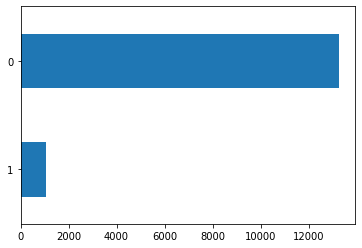

In [9]:
claims_data['claim'].value_counts().sort_values().plot(kind = 'barh')
plt.show()

 El dataset contiene un balance de frases no verificables mucho mayor que de frases verificables. Esto tiene un impacto en el entrenamiento del modelo y en el resultado final.

In [10]:
# Set que contenga todos los names entities encontrados para despues agregarlos como tags al tokenizer
entities = set()
# Pasar todos los textos por su respectivo modelo de spacy para hacer el NER
for lang, spacy_model in tqdm(zip(langs, spacy_models)):
  nlp = spacy_model.load()
  tqdm.pandas()
  claims_data[f'text_{lang}'] = claims_data[f'text_{lang}'].progress_apply(spacy_ner_replace, nlp=nlp, entities=entities)

In [12]:
def find_ne(text):
  """
  Retorna un booleano que indica si el texto contiene un named entity o no.
  """
  tkn = text.split(' ')
  for t in tkn:
    if '[' in t:
      return True
  return False

def find_ne_row(row):
  """
  Aplica la función anterio a una fila de pandas
  """
  return (find_ne(row['text_es'])) or (find_ne(row['text_en'])) or (find_ne(row['text_fr']))

claims_data['has_ne'] = claims_data.apply(find_ne_row, axis=1)


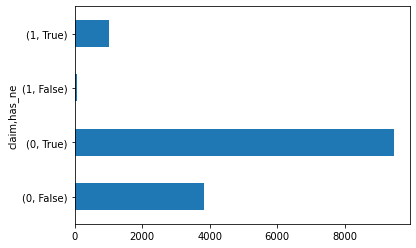

In [17]:
claims_data.groupby(['claim', 'has_ne']).agg('count')['_id'].plot(kind = 'barh')
plt.show()

De los textos que son frases verificables, casi todos tiene algún named entity. 

In [12]:
# Crear los dataframes de training, validation y testing para cada idioma. 
dataframes = {}

for l in langs:
  dfs = {}
  for t in ['training', 'testing', 'validation']:
    dfs[f'{t}_set_X'] = claims_data[claims_data['type'] == t][f'text_{l}']
    dfs[f'{t}_set_y'] = claims_data[claims_data['type'] == t]['claim']
  dataframes[l] = dfs

In [13]:
# Crear un BERT tokenizer usando el modelo pre-entrenado junto con los tags que creamos con el NER
def create_tokenizer(pre_trained_model, additional_tags):
  tok = BertTokenizer.from_pretrained(pre_trained_model)
  num_added_toks = tok.add_tokens(additional_tags)
  return tok

In [14]:
classes = ['Not Claim', 'Claim']
# Un BERT diferente para cada idioma. Cada uno está entrenado en un corpus diferente.
# El sistema de votación está pensado para mitigar los cezgos que tenga cada uno.
berts = {'en': 'bert-base-cased', 'es':'dccuchile/bert-base-spanish-wwm-cased', 'fr':'claudelkros/bert-base-french'}
tokenizers = {l: create_tokenizer(b, list(entities))  for l,b in zip(berts.keys(), berts.values())}

In [15]:
class ClaimsDataset(Dataset):
  """ 
  Clase que contiene el dataset y realiza el encoding para cada texto.
  """

  def __init__(self, texts, y, tokenizer, max_len):
    # Reset para evitar problemas con los índices
    texts = texts.reset_index(drop=True)
    y = y.reset_index(drop=True)
    self.texts = texts.to_numpy()
    self.y = y.to_numpy()
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self): return len(self.y)

  def __getitem__(self, idx):
    return [self.cats[idx], self.conts[idx], self.y[idx]]
  
  def __getitem__(self, idx):
    text = self.texts[idx]
    y = self.y[idx]

    encoding = self.tokenizer.encode_plus(
      text,
      # Tokens específicos de BERT
      add_special_tokens=True,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
      max_length=self.max_len,
      # Agregar 0s al final para que todos los ejemplos sean del mismo tamaño
      pad_to_max_length=True,
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'y': torch.tensor(y, dtype=torch.long)
    }

In [16]:
# Cargar cada dataset en un DataLoader de pytorch
all_data = {}
for lang in langs:
  data = {}
  for X, y, t in [('training_set_X', 'training_set_y', 'training'), ('testing_set_X', 'testing_set_y', 'testing'), ('validation_set_X', 'validation_set_y', 'validation')]:
    # Cada dataset tiene su propio tokenizer según su idioma
    ds = ClaimsDataset(
        texts= dataframes[lang][X],
        y = dataframes[lang][y],
        tokenizer = tokenizers[lang],
        max_len= MAX_TEXT_SIZE)
    # El batch size de 16 se eligió basado en las limitaciones de memoria del GPU de Google Collab. BERT pre-entrenado toma por si solo bastante espacio
    data[t] =  DataLoader(ds, batch_size=16)
  all_data[lang] = data

## Modelo:
El modelo está basado en los modelos de la biblioteca hugginface que utilizan BERT para clasificación de textos. Carga un BERT pre-entrenado según el lenguage y utiliza la última layer para hacer el fine tunning.

In [17]:
class ClaimsClassifier(nn.Module):

  def __init__(self, classes, bert_name, tokenizer):
    super(ClaimsClassifier, self).__init__()
    # Cargar el modelo pre-entrenado
    self.bert = BertModel.from_pretrained(bert_name)
    # Agregar los tokens nuevos que creamos al modelo
    self.bert.resize_token_embeddings(len(tokenizer)) 
    
    layers = []
    # Un layer para procesar la última layer de BERT
    layers.append(nn.Linear(self.bert.config.hidden_size, 2))
    self.layers = nn.Sequential(*layers)

  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    return self.layers(pooled_output)

In [18]:
def run_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  """
  Ejecuta el training para un epoch del modelo. 
  """
  # Poner el modelo en modo training
  model = model.train()
  losses = []
  
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["y"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return np.mean(losses)

In [19]:
def run_eval(model, data_loader, loss_fn, device):
  """
  Calcula el loss para el validation set en cada epoch.
  """
  model = model.eval()
  losses = []

  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["y"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return np.mean(losses)

In [20]:
def get_predictions(model, data_loader):
  """
  Aplica el modelo para el test set y retorna las clasificaciónes del modelo, junto con las probabilidades de cada clase.
  """
  model = model.eval()
  
  texts = []
  all_predictions = []
  probabilities = []
  y_true = []

  with torch.no_grad():
    for d in tqdm(data_loader):

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["y"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = outputs

      all_predictions.extend(preds)
      probabilities.extend(probs)
      y_true.extend(targets)

  all_predictions = torch.stack(all_predictions).cpu()
  probabilities = torch.stack(probabilities).cpu()
  y_true = torch.stack(y_true).cpu()
  return all_predictions, probabilities, y_true

In [21]:
for lang in langs:
  # Para cada lenguage creamos un modelo pre-entrenado
  model = ClaimsClassifier(classes, berts[lang], tokenizers[lang])
  model = model.to(device)
  # AdamW de huggingface con los parámetros recomendados para sequence classification
  optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
  total_steps = len(data['training']) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  optimal_loss = sys.maxsize


  for epoch in tqdm(range(EPOCHS)):
    
    train_loss = run_epoch(model, all_data[lang]['training'], loss_fn, optimizer, device, scheduler)
    print(f'Training loss :{train_loss}')

    val_loss = run_eval(model, all_data[lang]['validation'], loss_fn,device)
    print(f'Validation loss :{val_loss}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < optimal_loss:
      # Guardamos el mejor modelo según nuestra métrica
      torch.save(model.state_dict(), base_path+f'/{lang}_3.pt')
      optimal_loss = val_loss
  # Volver a poner el modelo en el CPU para evitar problemas de memoria con el GPU.
  model = model.cpu()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Training loss :0.205833928067609



Validation loss :0.15755920208961008



Training loss :0.0966173368871217



Validation loss :0.17080333872166062



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Training loss :0.22727052533551523



Validation loss :0.1539685381132932



Training loss :0.14417441103643616



Validation loss :0.15671720763757116



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Training loss :0.2776811421131419



Validation loss :0.24453418151963324



Training loss :0.27158669769342714



Validation loss :0.24238875555613684



In [22]:
# Aplicar el modelo en el test set por cada lenguage
result_df = pd.DataFrame()
for lang in langs:
  model = ClaimsClassifier(classes, berts[lang], tokenizers[lang])
  model.load_state_dict(torch.load(base_path+f'/{lang}_3.pt'))
  model = model.to(device)

  y_pred, y_pred_probs, y_test = get_predictions(model, all_data[lang]['testing'])
  result_df['y_true'] = y_test
  result_df[f'y_pred_{lang}'] = y_pred
  print(lang)
  print(classification_report(y_test, y_pred, target_names=['Not Claim', 'Claim']))


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



en
              precision    recall  f1-score   support

   Not Claim       0.95      0.99      0.97      3999
       Claim       0.71      0.26      0.38       307

    accuracy                           0.94      4306
   macro avg       0.83      0.62      0.67      4306
weighted avg       0.93      0.94      0.93      4306




es
              precision    recall  f1-score   support

   Not Claim       0.96      0.97      0.97      3999
       Claim       0.55      0.44      0.49       307

    accuracy                           0.93      4306
   macro avg       0.76      0.71      0.73      4306
weighted avg       0.93      0.93      0.93      4306




fr
              precision    recall  f1-score   support

   Not Claim       0.93      1.00      0.96      3999
       Claim       0.00      0.00      0.00       307

    accuracy                           0.93      4306
   macro avg       0.46      0.50      0.48      4306
weighted avg       0.86      0.93      0.89      4306



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# "Votación", si alguno de los 3 modelos da positivo a frase verificable se considera verificable
result_df['summed'] = result_df['y_pred_en'] + result_df['y_pred_fr'] + result_df['y_pred_es']
result_df['summed'] = result_df['summed'].apply(lambda s: 1 if s > 0 else 0)

In [24]:
print(classification_report(result_df['y_true'], result_df['summed'], target_names=['Not Claim', 'Claim']))

              precision    recall  f1-score   support

   Not Claim       0.96      0.97      0.97      3999
       Claim       0.56      0.48      0.51       307

    accuracy                           0.94      4306
   macro avg       0.76      0.72      0.74      4306
weighted avg       0.93      0.94      0.93      4306



## Resultados

*   Todas las métricas son considerablemente mejores en las frases no verificables, que se puede atribuir en parte a la sobrecarga de estas en el dataset. 
*   El modelo en inglés es el que presenta mejor precisión, pero la exhaustividad (recall) sufre bastante. Lo que implica un número grande de falsos negativos en la clase de frases verificables, osea frases verificables marcadas como no verificables.
*   El modelo final tiene una cantidad importante de falsos positivos y falsos negativos en la clase de frases verificables ("Claims") que disminuye considerablemente la precisión y la exhaustividad. 
*   Las predicciones después de la votación mejoran el f1 por poco. 



### Mejoras para una futura versión


*   Hay modelos de BERT pre-entrenados para cada lenguaje, como CamemBERT para el frances,  que me hubiera gustado probar pero la estructura es diferente y no encajaba con el diseño.
*   También el NER de spacy tiene bastantes fallos que se podrían revertir si se entrenara un modelo por separado que lo hiciera.


